## Final Assignment - Fuel emission prediction

In [1]:
# if needed install packages using the following commands:
# !pip install missingno
# !pip install xgboost

In [2]:
import pandas as pd 
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# load the dataset
data = pd.read_csv('fuel_emissions.csv')

In [4]:
# file is irrelevant column, it represents the file where the entry was found
# also description and model have very high cardinality, and should probably be omitted
data = data.drop(columns=['file', 'description', 'model'])

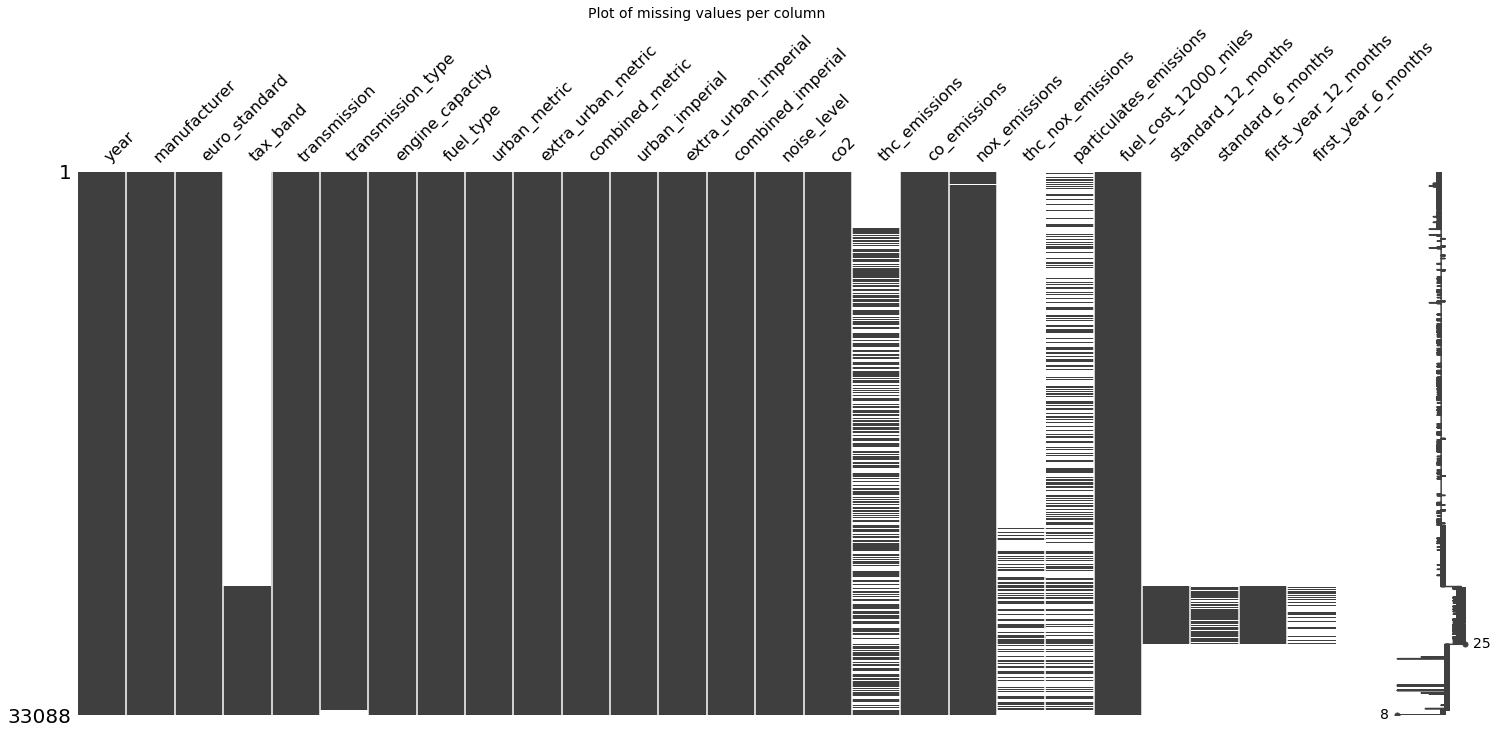

In [5]:
msno.matrix(data)
plt.title('Plot of missing values per column', size=14);

There are many variables that have missing values, like "thc_nox_emissions" and "first_year_6_months".  
Even more than 50% of the data could be missing! These variables will be dropped completely, as trying to interpolate in some way would probably lead to a distribution that is not close to the actual one.

In [6]:
missing = round(data.isnull().sum()/data.shape[0]*100, 2)
high_missing = sorted([(x,y) for x,y in zip(missing, missing.index)if x>20], key=lambda x: x[0], reverse=True)
high_missing_cols = [x[1] for x in high_missing]
high_missing

[(95.71, 'first_year_6_months'),
 (91.16, 'standard_6_months'),
 (89.37, 'standard_12_months'),
 (89.37, 'first_year_12_months'),
 (83.59, 'thc_nox_emissions'),
 (76.31, 'tax_band'),
 (60.18, 'particulates_emissions'),
 (50.17, 'thc_emissions')]

In [7]:
data = data.drop(columns=high_missing_cols)
# drop the columns where fuel_cost_12000_miles is missing (as it is the variable to be predicted)
data = data[data['fuel_cost_12000_miles'].notna()].reset_index().drop(columns='index')

In [8]:
# transmission type is probably related to transmission, so filling missing values can be done using the mode per transmission grouping
data['transmission_type'] = data.groupby('transmission')['transmission_type'].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [9]:
# fill the rest of the categorical columns with their mode
cat_columns = ['manufacturer', 'transmission', 'transmission_type', 'fuel_type']

for col in cat_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

Not all types of fuel appear the same amount of times. Some can be grouped together.

In [10]:
fuel_mapper = {'Petrol':'Petrol',
               'Diesel': 'Diesel', 'Diesel Electric': 'Diesel', 'CNG': 'Diesel', 'Electricity/Diesel': 'Diesel', 
               'Electricity': 'Diesel',
               'Petrol / E85 (Flex Fuel)': 'Petrol Hybrid', 'Petrol Hybrid': 'Petrol Hybrid', 
               'Petrol / E85': 'Petrol Hybrid', 'LPG / Petrol': 'Petrol Hybrid', 'LPG': 'Petrol Hybrid',
               'Petrol Electric': 'Petrol Hybrid', 'LPG / Petrol': 'Petrol Hybrid', 
               'Electricity/Petrol': 'Petrol Hybrid',
               }
               
data['fuel_type_mapped'] = data['fuel_type'].map(fuel_mapper)

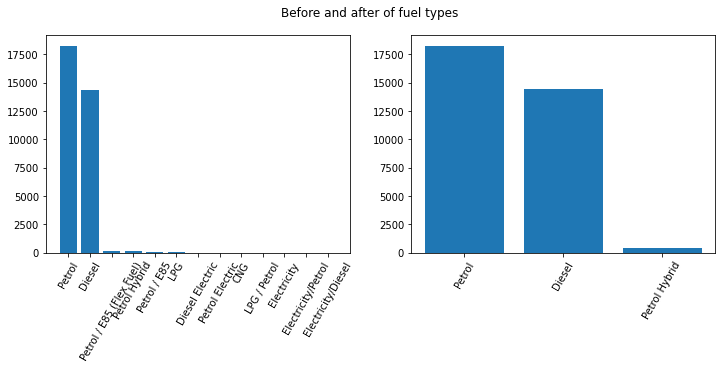

In [11]:
plt.figure(figsize=(12,4))
plt.suptitle('Before and after of fuel types')
#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1=plt.subplot(121)
plt.bar(data['fuel_type'].value_counts().index, data['fuel_type'].value_counts().tolist())
plt.xticks(rotation=60)

ax2=plt.subplot(122, sharey=ax1)
plt.bar(data['fuel_type_mapped'].value_counts().index, data['fuel_type_mapped'].value_counts().tolist())
plt.xticks(rotation=60);

There are variables with very **skewed distribution**, possibly having outliers or wrong entries

Check for skewness. Often, **skewed distribution reveal outliers**    
noise_level, engine_capacity and nox_emissions are very skewed

In [12]:
cat_columns = ['manufacturer', 'transmission', 'transmission_type', 'fuel_type_mapped']

# check for skewness
data[[col for col in data.columns if col not in cat_columns]].skew().sort_values()

noise_level               -6.599748
year                      -0.105129
euro_standard             -0.098381
extra_urban_imperial       0.240242
urban_imperial             0.651336
combined_imperial          0.885943
co_emissions               1.418535
extra_urban_metric         1.451192
co2                        1.464434
fuel_cost_12000_miles      1.495822
urban_metric               1.600537
combined_metric            1.625529
engine_capacity            2.172169
nox_emissions            179.686084
dtype: float64

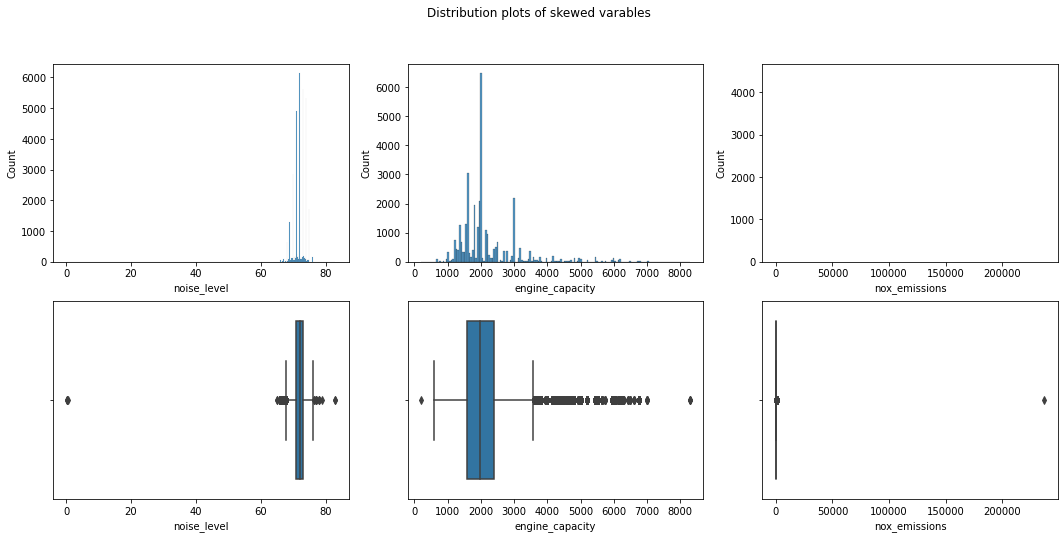

In [13]:
skewed_cols = ['noise_level', 'engine_capacity', 'nox_emissions']

plt.figure(figsize=(18,8))
plt.suptitle('Distribution plots of skewed varables')
for n, col in zip(range(1,4), skewed_cols):
    # plot the distribution
    plt.subplot(2,3,n)
    sns.histplot(data[col])
    # plot a boxplot to reveal outliers beneath the distribution plot
    plt.subplot(2,3,n+3)
    sns.boxplot(data[col])


In [14]:
# most noise levels are around 70, the values here are like 0.2, 0.3 etc --> replace with 72, 73,..
data['noise_level'][data['noise_level']<50] = data['noise_level'][data['noise_level']<50]*10+70

# one probably wrong entry for nox_emissions, it looks like the actual value was multiplied by 1000
data['nox_emissions'][data['nox_emissions']>1000] = data['nox_emissions'][data['nox_emissions']>1000]/1000

# engine's capacity distrubution is skewed, but it doesn't look like there are outliers

In [15]:
data =  data.drop(columns='fuel_type')
X = data[[col for col in data.columns if col != 'fuel_cost_12000_miles']]
y = data['fuel_cost_12000_miles']

# split the data in train-test (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=512)

The metric that will be used to assess model performance needs to be defined.  
To do that, it is best to know the distribution of the variable that we are trying to predict.  
The distribution is slightly skewed on the right, so typical metrics like MSE and RMSE can be used.

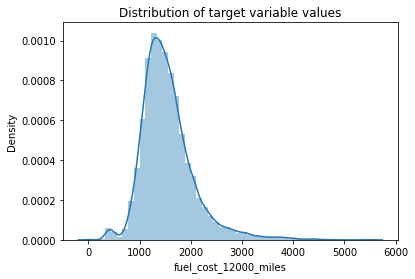

In [16]:
sns.distplot(y_train)
plt.title('Distribution of target variable values');

In [17]:
# split the data in numeric and categorical types
X_train_num = X_train[[col for col in X_train.columns if col not in cat_columns]]
X_test_num = X_test[[col for col in X_test.columns if col not in cat_columns]]

# remote manufactorer and transmission as it is very high dimensional
X_train_cat = X_train[['transmission_type', 'fuel_type_mapped']]
X_test_cat = X_test[['transmission_type', 'fuel_type_mapped']]

In [18]:
drop_enc = OneHotEncoder(drop='first')

X_train_ohe = drop_enc.fit_transform(X_train_cat)
X_test_ohe = drop_enc.transform(X_test_cat)

# and join back to the dataset
X_train = np.concatenate((X_train_num, X_train_ohe.todense()), axis=1)
X_test = np.concatenate((X_test_num, X_test_ohe.todense()), axis=1)

In [19]:
def train_pipe(imputer_neighbors, prepr_scaler, regression_model, X_train, y_train, X_test, y_test):

    # fill the rest of the missing values using knnimputer
    imputer = KNNImputer(n_neighbors=imputer_neighbors, weights='uniform', metric='nan_euclidean')

    # scale the data using min max scaler
    scaler = prepr_scaler

    # run an XGBoost regressor 
    regressor = regression_model


    reg_pipe = Pipeline(steps = [('imputer', imputer),
                                 ('scaler', scaler),
                                 ('regressor', regressor)])

    rmse_cv = [np.sqrt(-neg_mse) for neg_mse in cross_val_score(reg_pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')]
    print(f'Mean of RMSE in {type(regressor).__name__} pipeline, using 5-fold cross validation is: {np.mean(rmse_cv):.02f}')

    reg_pipe.fit(X_train, y_train)
    yhat = reg_pipe.predict(X_test)
    rmse_test = mean_squared_error(y_test, yhat, squared=False)
    print(f'RMSE in {type(regressor).__name__} pipeline on test set is: {rmse_test:.02f}')

    return reg_pipe

Run multiple algorithms using base configuration to find the best performing one.

In [20]:
print('XGBoost Regression')
xgb_pipe = train_pipe(20, MinMaxScaler(), XGBRegressor(n_jobs=-1), X_train, y_train, X_test, y_test)

print('Linear Regression')
linreg_pipe = train_pipe(20, MinMaxScaler(), LinearRegression(n_jobs=-1), X_train, y_train, X_test, y_test)

print('Ridge Regression')
ridge_pipe = train_pipe(20, MinMaxScaler(), Ridge(), X_train, y_train, X_test, y_test)

print('Support Vector Regression')
svr_pipe = train_pipe(20, MinMaxScaler(), SVR(), X_train, y_train, X_test, y_test)

print('KNeighbors Regression')
knn_pipe = train_pipe(20, MinMaxScaler(), KNeighborsRegressor(n_jobs=-1), X_train, y_train, X_test, y_test)

print('Random Forest Regression')
rf_pipe = train_pipe(20, MinMaxScaler(), RandomForestRegressor(n_jobs=-1), X_train, y_train, X_test, y_test)

XGBoost Regression
Mean of RMSE in XGBRegressor pipeline, using 5-fold cross validation is: 38.85
RMSE in XGBRegressor pipeline on test set is: 27.70
Linear Regression
Mean of RMSE in LinearRegression pipeline, using 5-fold cross validation is: nan
RMSE in LinearRegression pipeline on test set is: 154.44
Ridge Regression
Mean of RMSE in Ridge pipeline, using 5-fold cross validation is: 160.13
RMSE in Ridge pipeline on test set is: 154.84
Support Vector Regression
Mean of RMSE in SVR pipeline, using 5-fold cross validation is: 270.07
RMSE in SVR pipeline on test set is: 243.81
KNeighbors Regression
Mean of RMSE in KNeighborsRegressor pipeline, using 5-fold cross validation is: 73.68
RMSE in KNeighborsRegressor pipeline on test set is: 65.43
Random Forest Regression
Mean of RMSE in RandomForestRegressor pipeline, using 5-fold cross validation is: 41.60
RMSE in RandomForestRegressor pipeline on test set is: 30.60


The model that performs best, as judged by RMSE metric, is XGBoost regression.  
The parameters will be further explored to try to achieve better results.

In [28]:
# fill the rest of the missing values using knnimputer
imputer = KNNImputer(weights='uniform', metric='nan_euclidean')

# scale the data using min max scaler
scaler = MinMaxScaler()

# run an XGBoost regressor 
regressor = XGBRegressor(n_jobs=-1)

reg_pipe = Pipeline(steps = [('imputer', imputer),
                             ('scaler', scaler),
                             ('regressor', regressor)])

# define values for grid search
grid_params = {'imputer__n_neighbors': [20, 23, 24, 25, 26, 27],
               'regressor__max_depth': [7, 8, 9, 10],
               'regressor__eta': [0.25, 0.3, 0.35],
               #'regressor__grow_policy': ['depthwise', 'lossguide'],
               }

grid = GridSearchCV(reg_pipe, cv=3, n_jobs=-1, param_grid=grid_params, scoring='neg_mean_squared_error', verbose=10)

# fit the model
grid.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                            

In [36]:
imputer = KNNImputer(n_neighbors=grid.best_params_['imputer__n_neighbors'], 
                     weights='uniform', 
                     metric='nan_euclidean')
scaler = MinMaxScaler()
regressor = XGBRegressor(n_jobs=-1, 
                         eta=grid.best_params_['regressor__eta'], 
                         max_depth=grid.best_params_['regressor__max_depth']
                         )
reg_pipe = Pipeline(steps = [('imputer', imputer),
                             ('scaler', scaler),
                             ('regressor', regressor)])
reg_pipe.fit(X_train, y_train)
yhat = reg_pipe.predict(X_test)
rmse_test = mean_squared_error(y_test, yhat, squared=False)
print(f'RMSE in XGBoost Regression pipeline, trained on best hyperparameters on test set is: {rmse_test:.02f}')

RMSE in XGBoost Regression pipeline, trained on best hyperparameters on test set is: 24.80
